In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tweet-sentiment-extraction/test.csv
/kaggle/input/tweet-sentiment-extraction/sample_submission.csv
/kaggle/input/tweet-sentiment-extraction/train.csv


In [2]:
import numpy as np # algebra
import pandas as pd # data frames & processing, CSV file I/O 

# Visualization, graphs & plots
import matplotlib.pyplot as plt
import plotly.graph_objects as go # plots & graphics 
from plotly.subplots import make_subplots 
import seaborn as sns # plots & graphics

# SpaCy
import spacy
from spacy.util import compounding
from spacy.util import minibatch
from thinc.neural.optimizers import Adam # for hyperparameter tuning
from thinc.neural import Model # for hyperparameter tuning

# Utilities & helpers
from tqdm import tqdm_notebook as tqdm # progress bar
import time
import os
import re # Regex library
import random
import timeit # measuring execution time
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore') #Ignore "future" warnings and Data-Frame-Slicing warnings.

In [3]:
DATA_BASE_PATH = '../input/tweet-sentiment-extraction/' 

# Read training & test data as pandas-dataframe (ending _df)
train_df = pd.read_csv(DATA_BASE_PATH + 'train.csv') 
test_df = pd.read_csv(DATA_BASE_PATH + 'test.csv')

In [4]:
print(f"Train-Data shape is: {train_df.shape}") 
print(f"Test-Data shape is: {test_df.shape}")

Train-Data shape is: (27481, 4)
Test-Data shape is: (3534, 3)


In [5]:
train_df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [6]:
test_df.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


In [7]:
train_df.dropna(inplace = True, how = 'any')

In [8]:
train_df.sample(15)

,textID,text,selected_text,sentiment
25300,0adf28c5a1,feels very very sick hmph.,sick,negative
20152,0073bdbc5f,I wanna see the Jonas Brothers in concert..,I wanna see the Jonas Brothers in concert..,neutral
16236,9dea561ebe,i hear you.. it pisses me off haha,pisses,negative
5593,265aee2e15,Super pumped to do the 'Relay for Life' tonite...,Super pumped to do the 'Relay for Life' tonite...,neutral
5774,9f7c258724,i am on BLAZE and my head hurts.,hurts.,negative
20312,4cdeed3cba,It was truly awful,It was truly awful,negative
7705,08a5586215,Matt Weiters` first at bat: fly out to RF,Matt Weiters` first at bat: fly out to RF,neutral
27305,badbf16c55,"Two months ago, I became worthless.",worthless.,negative
24980,fed99fb408,is so excited for this summer... Steve Winwood...,is so excited fo,positive
4096,2005f1cf47,yeah... i guess my password was also changed....,yeah... i guess my password was also changed.....,neutral


In [9]:
train_df.loc[[9710]]

,textID,text,selected_text,sentiment
9710,0cf61b6c7a,EEW Cheese. I hate cheese.,I hat,negative


In [10]:
train_df.loc[[1305]]

,textID,text,selected_text,sentiment
1305,969294b88a,live long and prosper,live long,positive


In [11]:
train_absolute_count = train_df["sentiment"].value_counts()
train_relative_count = train_df["sentiment"].value_counts(normalize = True)
test_relative_count = test_df["sentiment"].value_counts(normalize = True)

# Create figure and add traces
fig = make_subplots(1,3, subplot_titles = ('TRAIN data absolute amount',
                                           'TRAIN data relative amount', 
                                           'TEST data relative amount'))
for i in fig['layout']['annotations']:
            i['font'] = dict(size = 13)
  
fig.add_trace(go.Bar(x = train_absolute_count.index, y = train_absolute_count.values, 
                     marker_color = ['blue','green','red'], name= ''), row = 1, col = 1)

fig.add_trace(go.Bar(x = train_relative_count.index, y = train_relative_count.values,                     
                     marker_color = ['blue','green','red'], name= ''), row = 1, col = 2)

fig.add_trace(go.Bar(x = test_relative_count.index, y = test_relative_count.values,
                     marker_color = ['blue','green','red'], name= ''), row = 1, col = 3)


title_text = "Absolut and relative distribution of sentiments in train and test data"
fig.update_layout(title={'text': title_text})

# Define default go-layout for future use
default_layout =  go.Layout(  
    title = {                    
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    titlefont = {
     'size' : 15, 
     'color': 'black'
    },
    font = {
      'size' : 10 
    })

fig.update_layout(default_layout)

fig.show()

In [12]:
cache = """
train_max_len = max(train_df["TEXT_number_of_words"])
bins = np.linspace(0, train_max_len, train_max_len) # np.linspace takes following arguments: startpoint, endpoint, number of steps

# Cache tbd removed?
cache = plt.hist(train_df["TEXT_number_of_words"], bins, alpha=0.5, label = 'Number of words in "TEXT"')
cache = plt.hist(train_df["SELECTED_TEXT_number_of_words"], bins, alpha=0.5, label = 'Number of words in "SELECTED_TEXT"')
cache = plt.legend(loc = 'upper right')
cache = plt.style.use('seaborn-deep')
plt.gcf().set_size_inches(15, 7)  # Wow, there's really no set_size_cm ...but yea, a conversion via a pre-defined tuple could help here.
cache = plt.show()
"""

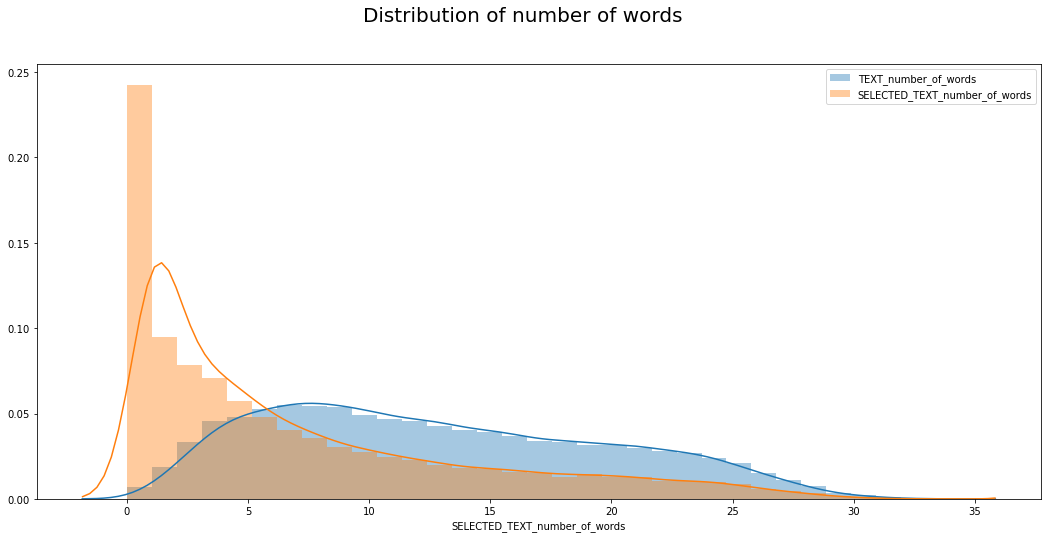

In [13]:
train_df["TEXT_number_of_words"] = train_df["text"].apply(lambda x: len(str(x).split()))  
train_df["SELECTED_TEXT_number_of_words"] = train_df["selected_text"].apply(lambda x: len(str(x).split()))
train_max_len = max(train_df["TEXT_number_of_words"])

fig = plt.figure(figsize=(18,8))
# Number of bins shall equal the max-length in train_df['text']
bins = np.linspace(0, train_max_len, train_max_len) 
# sns.distplot is a nice combination of sns.hist and sns.kdplot
plot1 = sns.distplot(train_df['TEXT_number_of_words'], 
                     bins = bins, 
                     label = 'TEXT_number_of_words')
plot1 = sns.distplot(train_df['SELECTED_TEXT_number_of_words'], 
                     bins =  bins,  
                     label = 'SELECTED_TEXT_number_of_words')  
cache = plt.legend() 

fig.suptitle('Distribution of number of words', fontsize = 20)

# Defining default parameter for plt.rc for later re-use.
params = {
    'figure.titlesize': 22, # fontsize of plot title / fig.suptitle
    'axes.titlesize': 14,   # fontsize of the axes title
    'axes.labelsize': 11,   # fontsize of the x and y labels    
    'xtick.labelsize': 11,  # fontsize of the tick labels
    'ytick.labelsize': 11,  # fontsize of the tick labels
    'legend.fontsize': 12,  # fontsize for legends (plt.legend(), fig.legend())
}

plt.rcParams.update(params)


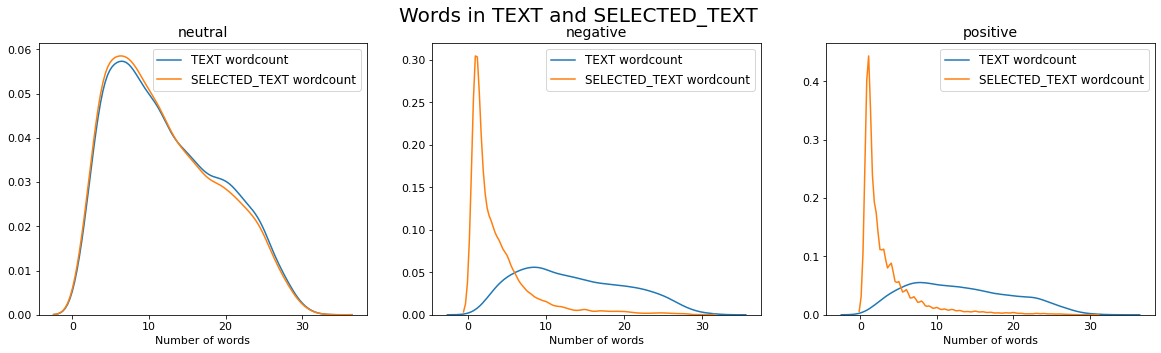

In [14]:
sentiments = ['neutral', 'negative', 'positive']
fig,ax = plt.subplots(nrows = 1, ncols = len(sentiments), figsize = (20,5))

for i, sentiment in enumerate(sentiments):
    plot2 = sns.kdeplot(train_df[train_df['sentiment'] == sentiment]['TEXT_number_of_words'],
                        ax = ax[i],
                        label = 'TEXT wordcount').set_title(sentiment) 
    plot2 = sns.kdeplot(train_df[train_df['sentiment'] == sentiment]['SELECTED_TEXT_number_of_words'],  
                        ax = ax[i],
                        label = 'SELECTED_TEXT wordcount') 
    ax[i].set_xlabel('Number of words')
    cache = plt.legend() 

fig.suptitle('Words in TEXT and SELECTED_TEXT', fontsize = 20)

params_3_figs = {
    'figure.titlesize': 18, # Fontsize of plot title / fig.suptitle
    'axes.titlesize': 14,   # Fontsize of the axes title
    'axes.labelsize': 14,   # Fontsize of the x and y labels    
    'xtick.labelsize': 14,  # Fontsize of the tick labels
    'ytick.labelsize': 14,  # Fontsize of the tick labels
    'legend.fontsize': 14,  # Fontsize for legends (plt.legend(), fig.legend())
}

plt.rcParams.update(params_3_figs) # Params defined above and re-used.


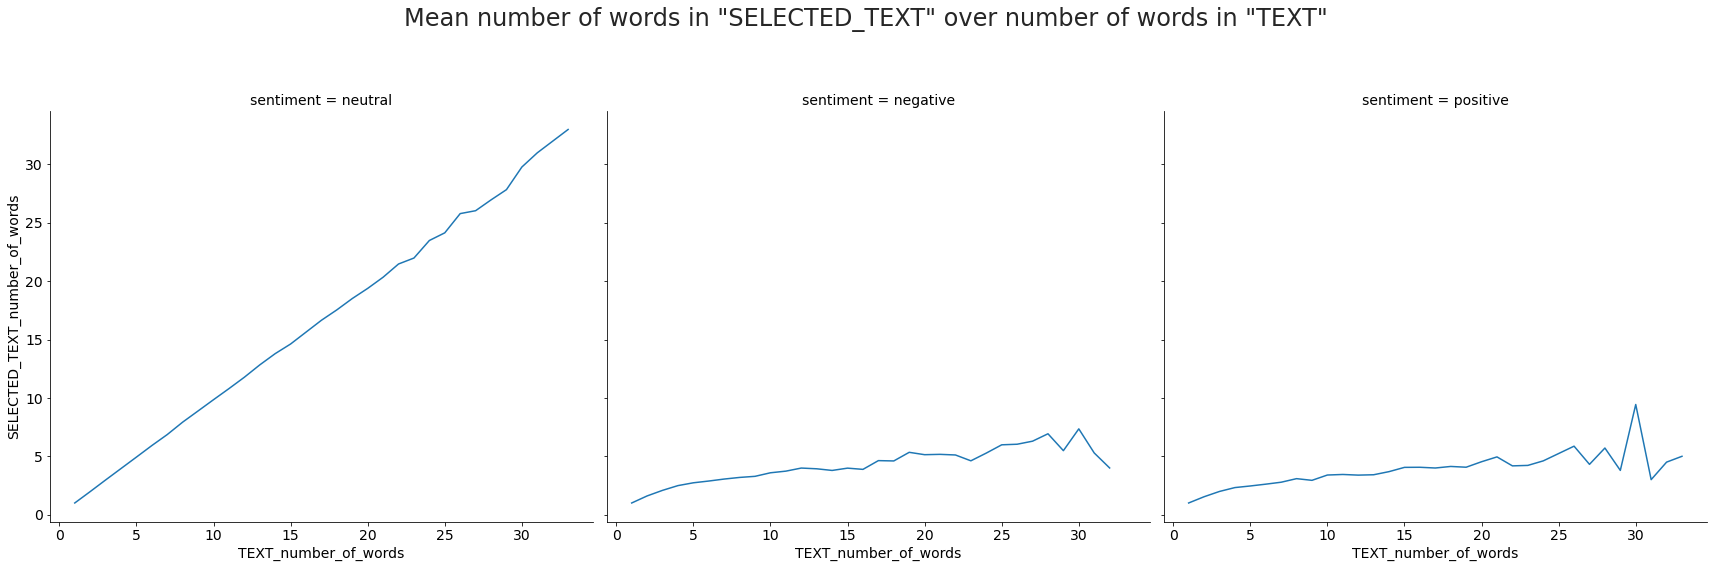

In [15]:
grid = sns.FacetGrid(train_df, col = 'sentiment', height = 8)
sns_default_font_scale = 1.6 # setting default font scale for sns for later use
grid.map(sns.lineplot, 'TEXT_number_of_words', 'SELECTED_TEXT_number_of_words', estimator = 'mean', ci = None)
grid.add_legend() 
plt.subplots_adjust(top = 0.8)
sns.set(font_scale = sns_default_font_scale) 
cache = grid.fig.suptitle('Mean number of words in "SELECTED_TEXT" over number of words in "TEXT"', fontsize = 24)

In [16]:
train_df['Diff_len_text_selected_text'] = train_df['TEXT_number_of_words'] - train_df['SELECTED_TEXT_number_of_words']

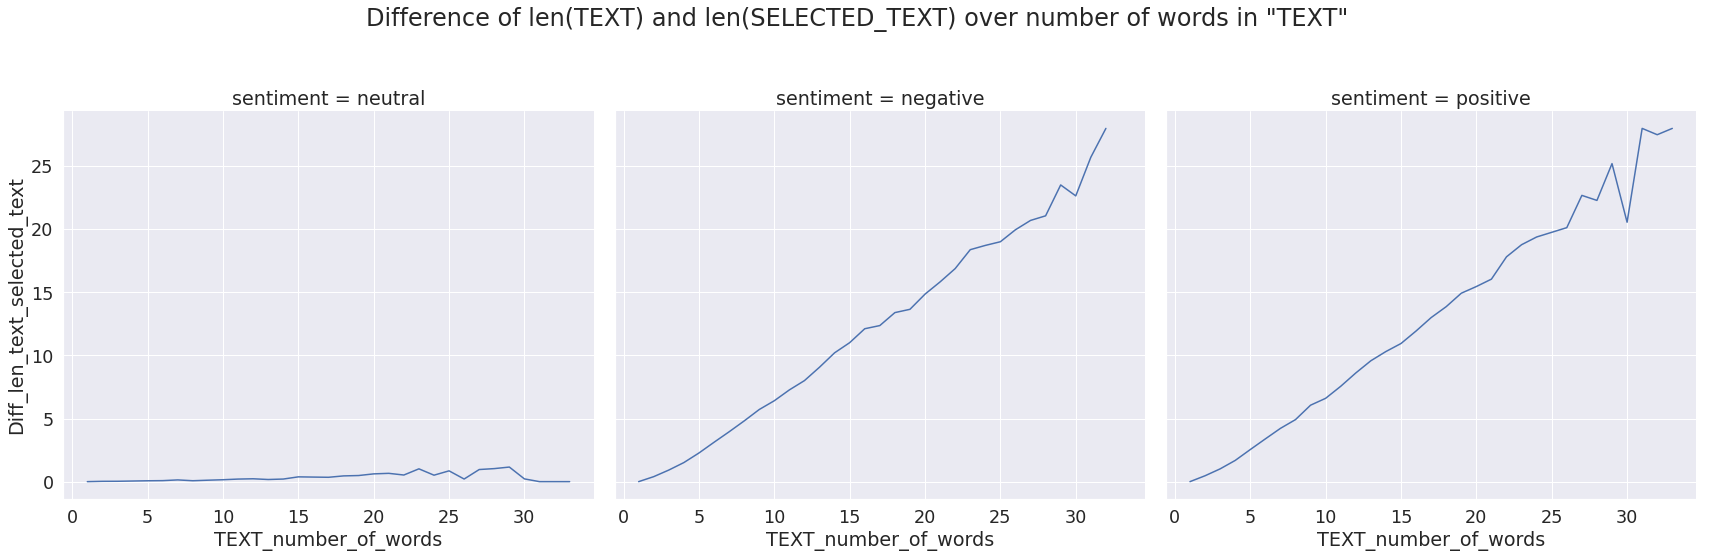

In [17]:
grid = sns.FacetGrid(train_df, col = 'sentiment', height = 8)
sns.set(font_scale = sns_default_font_scale) 
grid.map(sns.lineplot, 'TEXT_number_of_words', 'Diff_len_text_selected_text', ci = None)
grid.add_legend()
plt.subplots_adjust(top = 0.8)
cache = grid.fig.suptitle('Difference of len(TEXT) and len(SELECTED_TEXT) over number of words in "TEXT"', fontsize = 24)

In [18]:
fig_box = go.Figure()

for _, sentiment in enumerate(sentiments):
    # CHANGE HERE! You can change "Diff_len_text_selected_text" in below line to 
    # "TEXT_number_of_words" or "SELECTED_TEXT_number_of_words" to get the respective boxplots.  
    fig_box.add_trace(go.Box(y = train_df[train_df['sentiment'] == sentiment]['Diff_len_text_selected_text'], name = sentiment)) 

title_text = 'Boxplot diagram difference in len(text) and len(selected_text)'
fig_box.update_layout(title = {'text': title_text})
fig_box.update_layout(default_layout)
          
fig_box.show()


In [19]:
def startsOrEndsWithSpecialCharacter(rowString): 
    '''
    Returns a boolean for whether a given string starts OR ends with an unexpected characters
    '''
    # Check beginning of the string
    pattern = '^[\/_,.|;:#*~+-?!].*'
    value =  0 if (re.match(pattern, rowString) == None) else 1
    # Check ending: expected interpunctuation at the end of the selected text (! ? .) is allowed.  
    pattern = '.*[\/_,|;:#*~+-]$' 
    value = value | (0 if (re.match(pattern, rowString) == None) else 1)
    # Check ending for white spaces before ending on a spec. character. E.g. "hi ."
    value = value | endsWithAppendedSpecialCharactersAndWhitespace(rowString) 
    # print(re.match(pattern, rowString)) # for analysis, if needed
    return value

In [20]:
def startsWithPrependedSpecialCharactersAndWhitespace(rowString):   
    pattern = '(^[\/_|,;.:#*~+-!?]\s+.*)'
    # print(re.match(pattern, rowString)) 
    return 0 if (re.match(pattern, rowString) == None) else 1

# looking for stuff like ',so happy'
def startsWithPrependedSpecialCharactersNoWhitespace(rowString): 
    pattern = '(^[\/_|,;.:#*~+-](?!\s+).*)'
    # print(re.match(pattern, rowString))
    return 0 if (re.match(pattern, rowString) == None) else 1

# looking for stuff like 'so happy,') 
# expected interpunctuation at the end of the selected text (! ? .) is allowed
def endsWithAppendedSpecialCharactersNoWhitespace(rowString):  
    pattern = '.*(<\s)[\/_|,;:#*~+-]$'  
    # print(re.match(pattern, rowString))
    return 0 if (re.match(pattern, rowString) == None) else 1

# looking for stuff like 'so happy ,') 
def endsWithAppendedSpecialCharactersAndWhitespace(rowString):  
    pattern = '(.*\s+)?[\/_,.|;:#*~+-?!]$'
    # print(re.match(pattern, rowString))
    return 0 if (re.match(pattern, rowString) == None) else 1

In [21]:
startsOrEndsWithSpecialCharacter_series = []
startsOrEndsWithSpecialCharacter_series = train_df["selected_text"].apply(lambda x: startsOrEndsWithSpecialCharacter(x))
startsOrEndsWithSpecialCharacter_series = startsOrEndsWithSpecialCharacter_series[startsOrEndsWithSpecialCharacter_series > 0]
startsOrEndsWithSpecialCharacter_len = len((startsOrEndsWithSpecialCharacter_series[startsOrEndsWithSpecialCharacter_series == 1]))
print(f"There are {startsOrEndsWithSpecialCharacter_len} tweets"
      f"(= {startsOrEndsWithSpecialCharacter_len/train_df.shape[0] * 100:.2}%) that start or end with a special character pattern. \n"
      "Some examples look like this:")
train_df.loc[startsOrEndsWithSpecialCharacter_series.index].sample(10)[["textID", "text", "selected_text", "sentiment"]]

There are 2251 tweets(= 8.2%) that start or end with a special character pattern. 
Some examples look like this:


,textID,text,selected_text,sentiment
5429,2b37f61e33,"didnt enjoy having to say goodbye to alex, v e...","didnt enjoy having to say goodbye to alex, v e...",neutral
24697,96c822ad1e,its my birthday too but its the 10th of may ...,. happy,positive
20798,fcd9835a33,And now she also rides giant squids...who kne...,", love to you",positive
5605,c2574b4332,- Gig was awesome! Am exahausted and so dont w...,- Gig was awesome! Am exahausted and so dont w...,neutral
3473,4dafa796c5,"what about the dilfs? Oh wait, wrong month......",.HAPPY MOTHERS DAY,positive
18230,cc7953c4d1,__ that`s not good! hope you get better soon ...,__ that`s not good! hope you get better soon ...,neutral
26371,1d1e147bed,OH FACK U GAVE ME POLICE THATS SOME SERIOUSE ...,****,negative
23374,582abf3fd5,.. IN SWEATERS,.. IN SWEATERS,neutral
20374,82d589e1bc,Lol It`s like you have a cult.. haha,. haha,positive
20258,fb8a35bcb3,_Sweethearts Im following you but you aren`t o...,_Sweethearts Im following you but you aren`t o...,neutral


In [22]:
nonNeutralSentiment_df = train_df[train_df["sentiment"] != "neutral"]
nonNeutralSentimentsStartEndWithSpecialChar = nonNeutralSentiment_df.loc[nonNeutralSentiment_df.index.intersection(startsOrEndsWithSpecialCharacter_series[startsOrEndsWithSpecialCharacter_series == 1].index)]
print(f"There are {len(nonNeutralSentiment_df)} non-neutral sentiment tweets" 
      f" and {len(nonNeutralSentimentsStartEndWithSpecialChar) / len(nonNeutralSentiment_df) * 100:.1f}%"
      f" END with a special character")

There are 16363 non-neutral sentiment tweets and 8.0% END with a special character


In [23]:
spaCy_model = 'en_core_web_lg' 
nlp = spacy.load(spaCy_model)

In [24]:
spaCy_vocab_list = (list(nlp.vocab.strings))
# set ensures that all values are unique. All words converted to lower case.
spaCy_vocab_set = set([word.lower() for word in spaCy_vocab_list])

In [25]:
print(f"The loaded spaCy vocab {spaCy_model} contains unique lower case words: {len(spaCy_vocab_set)}")

The loaded spaCy vocab en_core_web_lg contains unique lower case words: 770253


In [26]:
def remove_special_characters(str1):
    '''
    Takes a string, removes(substituted by "") all special characters and URLS and returns it.
    '''
    url_pattern = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    # Remove URLs with re.sub(pattern, replacement, string)
    cache = re.sub(url_pattern, ' ', str(str1))  
    # Removing spec. characters
    character_pattern = '\||\,|\;|\.|\:|\#|\*|\~|\+|\-|\/|\_|\?|\!|\"|\'|\`|\(|\)|\=|\&|\%|\$|\§' 
    return re.sub(character_pattern, ' ', str(cache))

In [27]:
train_df['clean_text'] = train_df['text'].str.lower().apply(remove_special_characters)
train_df['clean_selected_text'] = train_df['selected_text'].str.lower().apply(remove_special_characters)
test_df['clean_text'] = test_df['text'].str.lower().apply(remove_special_characters)

# Create sets with unique words and update them 
train_text_vocab_set = set()
train_selected_text_vocab_set  = set()
test_text_vocab_set  = set()

# Apply set.update to fill the sets
train_df['clean_text'].str.lower().str.split().apply(train_text_vocab_set.update)
cache = train_df['clean_selected_text'].str.lower().str.split().apply(train_selected_text_vocab_set.update)
cache = test_df['clean_text'].str.lower().str.split().apply(test_text_vocab_set.update)

In [28]:
print(
    f"The used spaCy model contains unique words: {len(spaCy_vocab_set)}  \n"
    f"TRAIN-datas 'text' column contains unique words: {(len(train_text_vocab_set))}  \n"
    f"TRAIN-datas 'selected_text' column contains unique words: {len(train_selected_text_vocab_set)} \n"
    f"TEST-datas 'selected_text' column contains unique words: {len(test_text_vocab_set)} \n"
)

The used spaCy model contains unique words: 770253  
TRAIN-datas 'text' column contains unique words: 24887  
TRAIN-datas 'selected_text' column contains unique words: 17149 
TEST-datas 'selected_text' column contains unique words: 7040 



In [29]:
fraction_shared_words_train_text_to_spaCy = len(train_text_vocab_set.intersection(spaCy_vocab_set)) / (len(train_text_vocab_set))
fraction_shared_words_train_selected_text_spaCy = len(train_selected_text_vocab_set.intersection(spaCy_vocab_set)) / (len(train_selected_text_vocab_set))
fraction_shared_words_test_text_spaCy = len(test_text_vocab_set.intersection(spaCy_vocab_set)) / (len(test_text_vocab_set))
fraction_shared_words_test_text_train_text = len(test_text_vocab_set.intersection(train_text_vocab_set)) / (len(test_text_vocab_set))

In [30]:
fig = go.Figure([go.Bar(x = ["train['text'] & spaCy", "train['selected_text'] & spaCy", "test['text'] & spaCy", "test['text'] & train['text']"], 
                        y = [fraction_shared_words_train_text_to_spaCy, fraction_shared_words_train_selected_text_spaCy, fraction_shared_words_test_text_spaCy, fraction_shared_words_test_text_train_text], 
                        marker_color = ['blue','green','red'])])

title_text = 'Fraction of words contained in both sets for relevant pairs'
fig.update_layout(title={'text': title_text})
fig.update_layout(default_layout)
 
fig.show()

In [31]:
print(f"Only {len(train_selected_text_vocab_set.intersection(train_text_vocab_set)) / (len(train_selected_text_vocab_set)):.4f}%"
      f" of 'selected_text' is fully available in 'text',.. giving us {len(train_selected_text_vocab_set - train_text_vocab_set)} words which are cut off: \n")
print(train_selected_text_vocab_set - train_text_vocab_set)

Only 0.9899% of 'selected_text' is fully available in 'text',.. giving us 174 words which are cut off: 

{'presen', 'followe', 'sfunf', 'gr', 'wis', 'deserv', 'sor', 'enj', 'lovel', 'interventio', 'handsom', 'ood', 'laz', 'awesom', 'af', 'ies', 'motiva', 'soproudofyo', 'goodb', 'sug', 'wonde', 'agai', 'awa', 'compan', 'fac', 'craz', 'bumme', 'credi', 'amazi', 'worr', 'aga', 'realitychec', '>>', 'yout', 'twic', 'awes', 'bbbbrrrrrrrr', 'kew', 'nes', 'thoug', 'resi', 'summe', 'sonnnn', 'painf', 'lovesu', 'ev', 'aroun', 'forwar', 'eels', '2n', 'ignorin', 'forrea', 'weir', 'day<', 'terrib', 'ily<', 'crosse', 'ry', 'harde', 'shee', 'kis', 'circl', 'smilin', 'tomor', 'su', 'artis', 'depresse', 'personalit', 'onna', '79l0', 'sorr', 'norma', 'urg', 'rul', 'behin', 'aam', 'faile', 'sil', 'aweso', 'nervou', 'als', 'clea', 'ignor', 'morga', 'gu', 'recommen', 'enjoye', 'overwhelmi', 'tur', 'reques', 'dxd', 'ls', 'bastard', 'col', '5z10', 'owne', 'wort', 'depressi', 'usefu', 'wor', 'podcas', 'peopl'

In [32]:
train_clean_text_word_list = ' '.join([i for i in train_df['clean_text']]).split()  
train_clean_selected_text_word_list = ' '.join([i for i in train_df['clean_selected_text']]).split()  
test_clean_text_word_list = ' '.join([i for i in test_df['clean_text']]).split()  

# Calculate differences 
not_shared_train_text_to_spaCy = [word for word in train_clean_text_word_list if ((word in train_text_vocab_set) and (word not in spaCy_vocab_set))]
not_shared_train_selected_text_to_spaCy = [word for word in train_clean_selected_text_word_list if ((word in train_selected_text_vocab_set) and (word not in spaCy_vocab_set))]
not_shared_test_text_to_spaCy = [word for word in test_clean_text_word_list if ((word in test_text_vocab_set) and (word not in spaCy_vocab_set))]
not_shared_test_text_to_train_text = [word for word in test_clean_text_word_list if ((word in test_text_vocab_set) and (word not in train_text_vocab_set))]

Text(0.5, 1.0, 'Not shared words: train_selected_text and spaCy vocab')

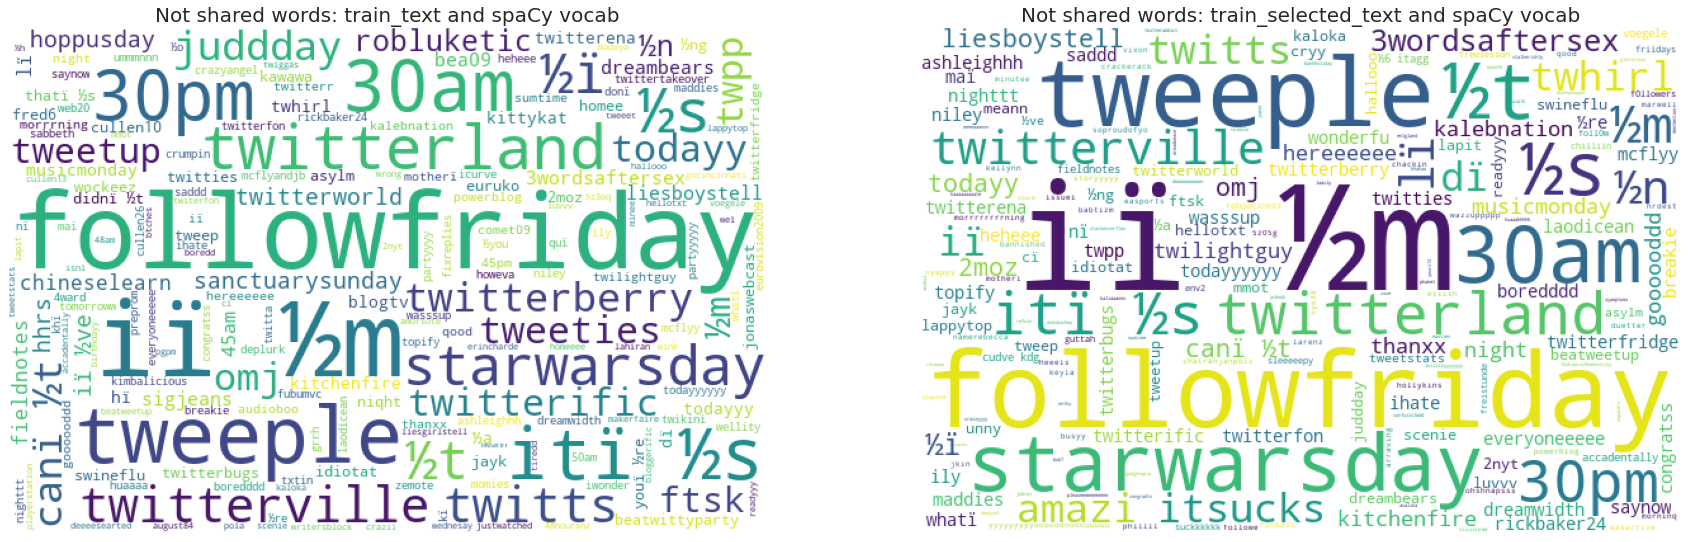

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[30, 15])
wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(not_shared_train_text_to_spaCy ))
titleFontsize = 20

ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Not shared words: train_text and spaCy vocab',fontsize = titleFontsize);

wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(not_shared_train_selected_text_to_spaCy))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Not shared words: train_selected_text and spaCy vocab',fontsize = titleFontsize)

Text(0.5, 1.0, 'Not shared words: Test_text to train_text')

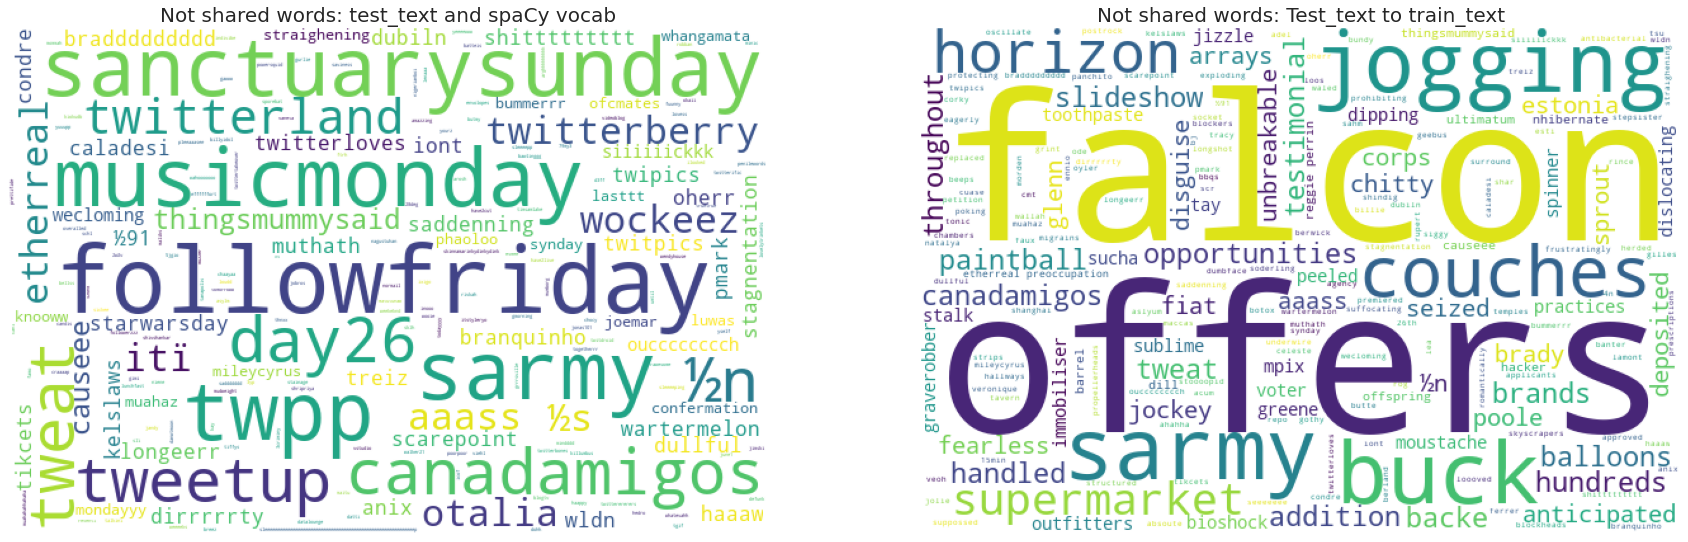

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[30, 15])
wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(not_shared_train_text_to_spaCy ))
titleFontsize = 20

wordcloud3 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(not_shared_test_text_to_spaCy))
ax1.imshow(wordcloud3)
ax1.axis('off')
ax1.set_title('Not shared words: test_text and spaCy vocab',fontsize=titleFontsize);

wordcloud4 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(not_shared_test_text_to_train_text))
ax2.imshow(wordcloud4)
ax2.axis('off')
ax2.set_title('Not shared words: Test_text to train_text',fontsize=titleFontsize)

In [35]:
def jaccard_score (str1, str2):
    '''
    Returns the Jaccard Score (intersection over union) of two strings.
    '''
    a = set(str1.lower().split())
    b = set(str2.lower().split())
    c = a.intersection(b)
    
    return float(len(c) / (len(a) + len(b) - len(c)))  

In [36]:
train_df["Jaccard_Score_text_selected_text"] = train_df.apply(lambda x: jaccard_score(str(x["text"]), str(x["selected_text"])), axis = 1) 
[avg_Jaccard_neu_train, avg_Jaccard_neg_train, avg_Jaccard_pos_train] = [train_df[train_df["sentiment"] == sentiment]["Jaccard_Score_text_selected_text"].mean() for sentiment in ["neutral", "negative", "positive"]]
avg_Jaccard_train = pd.Series(data = {'Avg Jaccard neutral': avg_Jaccard_neu_train, 'Avg Jaccard negative': avg_Jaccard_neg_train, "Avg Jaccard positive": avg_Jaccard_pos_train}, name = 'Jaccard Score per sentiment' )

print(f"Overall avg. Jaccard Score: {(avg_Jaccard_neu_train + avg_Jaccard_neg_train + avg_Jaccard_pos_train) / 3}")
print(avg_Jaccard_train)

Overall avg. Jaccard Score: 0.5431430422849246
Avg Jaccard neutral     0.976445
Avg Jaccard negative    0.338613
Avg Jaccard positive    0.314372
Name: Jaccard Score per sentiment, dtype: float64


In [37]:
# Code for creating a submission_df for base-line score: simply taking text as selected text
example = """submission_df = pd.read_csv( data_base_path + 'sample_submission.csv')
submission_df['selected_text'] = test_df['text']
submission_df.to_csv("submission.csv", index=False)
display(submission_df.head(10))"""

In [38]:
## Split the data into training and validation set.
train_val_split = 0.9

train_df_copy = train_df.copy() # Create a copy of the train_df to work with and not change stuff in-place
# Setting a random state for reproducable splits
train_set_df = train_df_copy.sample(frac = train_val_split, random_state = 42) 
val_set_df = train_df_copy.drop(train_set_df.index)
val_set_df.drop(['clean_text', 'clean_selected_text'], axis='columns', inplace = True)

# Get val_set for each sentiment
val_set_pos_df = val_set_df[val_set_df['sentiment'] == 'positive'].copy()
val_set_neg_df = val_set_df[val_set_df['sentiment'] == 'negative'].copy()
val_set_neu_df = val_set_df[val_set_df['sentiment'] == 'neutral'].copy()

In [39]:
print(
    f"Number of tweets in val_set_neu_df: {len(val_set_pos_df)}  \n"
    f"Number of tweets in val_set_neg_df: {(len(val_set_neg_df))}  \n"
    f"Number of tweets in val_set_pos_df: {len(val_set_neu_df)}")

Number of tweets in val_set_neu_df: 886  
Number of tweets in val_set_neg_df: 742  
Number of tweets in val_set_pos_df: 1120


In [40]:
def get_training_data(sentiment, splitAtLength = 0):
    '''
    Returns the training data in spaCy-required format for the given sentiment.
    If 'splitAtLength' is > 0, two none-empty arrays are returned: 
    first array containing the train_data with a 'text' containing more words than 'splitAtLength' 
    and the second arraycontaining train_data with 'text' containing number of words up to 'splitAtLength'.
    If splitAtLength is 0 or None, only one none-empty array 
    containing all train_data is returned, the second array is empty.
    
            Parameters:
                    sentiment (str): sentiment for which train_data needs to be returned
                    splitAtLength (int, optional): determins if and where the train_data is split

            Returns:
                    train_data (array): Returns the train data in an array, or array of arrays, if splitAtLength > 0.
    '''
    train_data_long = []
    train_data_short = []    
    
    for idx in train_set_df.index:
        if train_set_df.at[idx, 'sentiment'] == sentiment:
            text = train_set_df.at[idx,'text']
            len_text = len(text.split())            
            selected_text = train_set_df.at[idx,'selected_text']
            start = text.find(selected_text)
            end = start + len(selected_text)
            # create the train data in spaCy-required format. We can choose any "dummy_label" here
            # as we are anyway training just ONE model per sentiment:
            # all labels would be identical (e.g. positive) anyway.
            if (splitAtLength == None) or (splitAtLength == 0):
                   train_data_long.append((text, {"entities": [[start, end, "dummy_label"]]}))
            elif len(len_text) >= splitAtLength:
                   train_data_long.append((text, {"entities": [[start, end, "dummy_label"]]}))
            elif len(len_text) < splitAtLength:
                   train_data_short.append((text, {"entities": [[start, end, "dummy_label"]]}))
            else: print("something is wrong in getting training data")  
            
    return [train_data_long, train_data_short]


In [41]:
def get_validation_data(sentiment, model_type, splitAtLength = None):
    '''
    Returns the validation data used in training function
           
           Parameters:
                    sentiment (str): sentiment for which validation data needs to be returned
                    model_type (str): determins if data for short or long model is needed
                    splitAtLength (int, optional): determins if and where the data is split

           Returns:
                    train_data (array): Returns the train data in an array, or array of arrays, if splitAtLength > 0.
    '''
    if ((splitAtLength is None) or (splitAtLength == 0)):
        val_set_new_df = val_set_df[val_set_df['sentiment'] == sentiment].copy()  
        return val_set_new_df
    
    if (splitAtLength > 0) and (model_type == "short"): # tweets with length up to splitAtLength
        val_set_new_df = val_set_df[val_set_df["text"].str.split().str.len() < splitAtLength].copy()
        val_set_new_df = val_set_new_df[val_set_new_df['sentiment'] == sentiment].copy()
        return val_set_new_df
    
    if (splitAtLength > 0) and (model_type == "long"): # tweets with length > splitAtLength
        val_set_new_df = val_set_df[val_set_df["text"].str.split().str.len() >= splitAtLength].copy()
        val_set_new_df = val_set_new_df[val_set_new_df['sentiment'] == sentiment].copy()
        return val_set_new_df

In [42]:
def get_model_output_path(sentiment, splitAtLength = None, train_val_split = 0.90):
    '''
    Creates an easy to understand path for saving the model based on  the models parameters
    '''
    model_out_paths = []
    if splitAtLength == None or splitAtLength == 0:
        model_out_paths.append('models/model_'
                               + str(sentiment)
                               + '_splitAtLength_Longer_than'
                               + str(splitAtLength)
                               + '_train_val_split_'
                               + str(train_val_split))
        model_out_paths.append(None)
    elif splitAtLength != None:
        model_out_paths.append('models/model_' 
                               + str(sentiment)
                               + '_splitAtLength_Longer_than'
                               + str(splitAtLength)
                               + '_train_val_split_'
                               + str(train_val_split))
        model_out_paths.append('models/model_'
                               + str(sentiment)
                               + '_splitAtLength_Up_To'
                               + str(splitAtLength) + '_train_val_split_' 
                               + str(train_val_split))
    return model_out_paths

In [43]:
def save_model(output_dir, model , new_model_name, rank):
    '''
    Saves the model to an easy to understand path
    
        Parameters:
            output_dir (str): easy to understand path derived from models parameters
            model (model): the trained NLP model from spaCy            
            new_model_name (str): name for the model, NOT used for loading later
            rank (str): determins if the model is the best, 2nd best or 3rd best and adds it to save-path.
    '''
    output_dir = f'../working/{output_dir}_{rank}'
    if output_dir is not None:        
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        model.meta["name"] = new_model_name
        model.to_disk(output_dir)
        print("Saved model to", output_dir)  

In [44]:
results = {}

In [45]:
def train(sentiment, output_dir, epochs = 1, model = None, optimizer = None, dropout = 0.5, splitAtLength = 0, fill_no_predictions_with_text = False):
    '''
    Load the model, set up the pipeline and train the entity recognizer
    '''
    # define aborting conditions
    if epochs == 0 or epochs == None:
        return
    if output_dir == [] or output_dir == None:
        return

    # extract info if this model shall be for short or for long tweets from "output_dir"
    if "Longer_than" in output_dir:
        model_type = "long"
        # for long model, get 1st entry in array from get_training_data (used below)
        short_data = 0 
    elif "Up_To" in output_dir:
        model_type = "short" 
         # for short model, get 2nd entry in array from get_training_data (used below)
        short_data = 1
        
    # get train data relevant for this training session
    train_data = get_training_data(sentiment, splitAtLength = 0)[short_data]
    
    # get validation data relevant for this training session
    val_data = get_validation_data(sentiment, model_type, splitAtLength = splitAtLength)
   
    if output_dir == None:
        return 
   
    if model is not None:
        nlp = spacy.load(output_dir)  # load existing spaCy model to continue training
        print(f'Loaded model {model}')
    else:
        nlp = spacy.blank("en")  # create blank Language class
        print("Created blank 'en' model")
    
    # create the built-in pipeline components and add them to the pipeline
    # nlp.create_pipe works for built-ins that are registered with spaCy
    if "ner" not in nlp.pipe_names:
        ner = nlp.create_pipe("ner")
        nlp.add_pipe(ner, last = True)
    # otherwise, get it so we can add labels
    else:
        ner = nlp.get_pipe("ner")
        print("Getting NER-pipe in spaCy model.")
    
    # add all labels available in train_data
    # we could adjust train_data to get more/different labels
    # this will be explained in detail later.
    for _, annotations in train_data:
        for ent in annotations.get("entities"):
            ner.add_label(ent[2])

    # get names of other pipes to disable them during training
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]
    with nlp.disable_pipes(*other_pipes):  # only train NER       
        if model is None:
            nlp.begin_training()
            optimizer = nlp.begin_training() if optimizer is None else optimizer
        else:
            nlp.resume_training() 
            optimizer = nlp.resume_training() if optimizer is None else optimizer

        # initialize values to avoid "referenced before assignment" issues.
        best_Jaccard_score, second_best_Jaccard_score, third_best_Jaccard_score = [0,0,0]
        last_update_best_model, last_update_2nd_best_model, last_update_3rd_best_model = [0,0,0]
        improvement_best, improvement_2ndbest, improvement_3rdbest = [0,0,0]
        
       
        # actual train-step
        for itn in tqdm(range(epochs)):
            random.shuffle(train_data)
            # batch up the examples using spaCy's minibatch
            # compounding(start batch size, end batch size,  compounding factor).
            batches = minibatch(train_data, size = compounding(1.0, 100.0, 1.15) )    
            losses = {}
            for batch in batches:
                texts, annotations = zip(*batch)
                nlp.update(texts,  # batch of texts
                                    annotations,  # batch of annotations
                                    drop = dropout,   # makes it harder to memorize data
                                    sgd = optimizer,
                                    losses=losses, 
                                    )
            
       # test model on validattion_df and measure time
            start = time.time()
            [avg_pred_jaccard, number_no_predictions] = val_predictions_and_calc_Jaccard(
                sentiment = sentiment,
                model = nlp,
                val_df = val_data,               
                fill_no_predictions_with_text = fill_no_predictions_with_text)
            ende = time.time()
            print("Losses", losses)
            print(f'Avg. Jaccard Score for sentiment "{sentiment}" is: {avg_pred_jaccard:.4f},'                  
                  f' Number of empty predictions: {number_no_predictions}')
            
            # keep track of top 3 models & save them                      
            if avg_pred_jaccard > best_Jaccard_score:
                        improvement_best = avg_pred_jaccard - best_Jaccard_score
                        best_Jaccard_score = avg_pred_jaccard
                        save_model(output_dir,
                                   model = nlp, 
                                   new_model_name = output_dir.split('/')[-1],
                                   rank = 'best')
                        last_update_best_model = itn + 1  
            elif avg_pred_jaccard > second_best_Jaccard_score:
                        improvement_2ndbest = avg_pred_jaccard - second_best_Jaccard_score
                        second_best_Jaccard_score = avg_pred_jaccard
                        save_model(output_dir,
                                   model = nlp,
                                   new_model_name = output_dir.split('/')[-1],
                                   rank = 'second_best')
                        last_update_2nd_best_model = itn + 1     
            elif avg_pred_jaccard > third_best_Jaccard_score:
                        improvement_3rdbest = avg_pred_jaccard - third_best_Jaccard_score
                        third_best_Jaccard_score = avg_pred_jaccard
                        save_model(output_dir,
                                   model = nlp,
                                   new_model_name = output_dir.split('/')[-1],
                                   rank = 'third_best')  
                        last_update_3rd_best_model = itn + 1   
            else: print("Model didn't perform better, therefore not saved.")    
                    
    
    if best_Jaccard_score > 0: # only if some progress was made:
        print(f'\n \n \nBest model reached {best_Jaccard_score:.4f} and was updated' 
              f' (+{improvement_best:.4f}) last in {last_update_best_model}th epoch \n'
              f'2nd best model reached {second_best_Jaccard_score:.4f} and was updated'
              f' (+{improvement_2ndbest:.4f}) last in {last_update_2nd_best_model}th epoch\n'
              f'3rd best model reached {third_best_Jaccard_score:.4f} and was updated' 
              f' (+{improvement_3rdbest:.4f})last in {last_update_3rd_best_model}th epoch')    

    log = str(splitAtLength) + '_' + str(model_type)
    results[log] = {'best_Jaccard_score': best_Jaccard_score,
                                  'sentiment': sentiment,
                                  'splitAtLength': splitAtLength,                              
                                  'model_type': model_type}

In [46]:
def make_predictions(text, model, fill_no_predictions_with_text):
    '''
    Predicts entities based on the given model.
    Set fill_no_predictions_with_text to TRUE for creating a valid (high scoring) submission.
    If fill_no_predictions_with_text is false; all no-predictions will be marked with
    "NO-PREDICTION" for fruther evaluation.
    '''
    doc = model(text)
    ent_array = []
    for ent in doc.ents:
        start = text.find(ent.text)
        end = start + len(ent.text)
        new_int = [start, end, ent.label_]
        ent_array.append([start, end, ent.label_])
    if fill_no_predictions_with_text:
        selected_text = text[ent_array[0][0]: ent_array[0][1]] if len(ent_array) > 0 else text
    else:
        selected_text = text[ent_array[0][0]: ent_array[0][1]] if len(ent_array) > 0 else "NO-PREDICTION"
    return selected_text

In [47]:
def val_predictions_and_calc_Jaccard (sentiment, model, val_df, fill_no_predictions_with_text):    
    val_df['prediction']  = val_df["text"].apply(str).apply(lambda x: make_predictions(x, model, fill_no_predictions_with_text))
    val_df['pred_jaccard'] = val_df.apply(lambda x: jaccard_score (str(x['selected_text']), str(x['prediction'])), axis = 1)
    return [val_df['pred_jaccard'].mean(), np.sum(val_df["prediction"] == "NO-PREDICTION")]           

In [48]:
'''
splitAtLength: Allows to create a model per sentiment for tweets longer than splitAtLength words
and another model for shorter tweets --> so two models per sentiment.
splitAtLength = 0 (default): means NO split at all --> 1 model per sentiment.
splitAtLength_list: Can contain one or multiple values which will be iterated over.
Use this for grid search for optimal length!
Median for positive and negative tweets is 12, so half of the tweets contain less than 
(or equal to) 12 words and the other half contains more.
'''
splitAtLength_list = [0] 

# Epochs for long and short model
epochs_long = 30
epochs_short = 30

dropout_rate = 0.2

'''
If fill_no_predictions_with_text is FALSE: all rows without a prediction will be marked with
"NO-PREDICTION" for further evaluation.
'''
fill_no_predictions_with_text = True 

# Optimizer options
ops = Model.ops
learn_rate = 0.0015 # default: 0.001
L2 = 1e-5 # L2 regularisation penatly. Default: 1e-6
max_grad_norm = 1.0 # avoiding exploding gradients. Default: 1
optimizer = Adam(ops, learn_rate, L2 = L2) 
optimizer.max_grad_norm = max_grad_norm

# Determin for which sentiments to train a model for.
# Neutral sentiment is skipped here, as we can't get a better score
# for neutral sentiment than just using text als selected_text.

train_for_sentiments = ['negative', 'positive']

## Start the training
for splitAtLength in splitAtLength_list:
    for sentiment in train_for_sentiments:
        # Gget model path and determin whether to train two or one model per sentiment based on 
        # the value of  'splitAtLength'. returns [model_path_long, []] if splitAtLength = 0. 
        # Returns two paths if splitAtLength > 0
        [model_path_long, model_paths_short]  = get_model_output_path(
            sentiment,
            splitAtLength = splitAtLength,
            train_val_split = train_val_split) 

        train(sentiment, 
              output_dir = model_path_long, 
              epochs = epochs_long, 
              model = None,
              optimizer = optimizer,
              dropout = dropout_rate, 
              splitAtLength = splitAtLength, 
              fill_no_predictions_with_text = fill_no_predictions_with_text)
        
        # Train for short model will only be executed if model_paths_short != [] 
        train(sentiment, 
              output_dir = model_paths_short, 
              epochs = epochs_short, 
              model = None,
              optimizer = optimizer, 
              dropout = dropout_rate,
              splitAtLength = splitAtLength, 
              fill_no_predictions_with_text = fill_no_predictions_with_text)

Created blank 'en' model


Losses {'ner': 30722.36544718896}
Avg. Jaccard Score for sentiment "negative" is: 0.3651, Number of empty predictions: 0
Saved model to ../working/models/model_negative_splitAtLength_Longer_than0_train_val_split_0.9_best
Losses {'ner': 25626.167071518106}
Avg. Jaccard Score for sentiment "negative" is: 0.3933, Number of empty predictions: 0
Saved model to ../working/models/model_negative_splitAtLength_Longer_than0_train_val_split_0.9_best
Losses {'ner': 22586.176401772787}
Avg. Jaccard Score for sentiment "negative" is: 0.4252, Number of empty predictions: 0
Saved model to ../working/models/model_negative_splitAtLength_Longer_than0_train_val_split_0.9_best
Losses {'ner': 20233.322107243985}
Avg. Jaccard Score for sentiment "negative" is: 0.3967, Number of empty predictions: 0
Saved model to ../working/models/model_negative_splitAtLength_Longer_than0_train_val_split_0.9_second_best
Losses {'ner': 18644.248060643156}
Avg. Jaccard Score for sentiment "negative" is: 0.3794, Number of empty

Losses {'ner': 32022.562572458555}
Avg. Jaccard Score for sentiment "positive" is: 0.4026, Number of empty predictions: 0
Saved model to ../working/models/model_positive_splitAtLength_Longer_than0_train_val_split_0.9_best
Losses {'ner': 27017.413903517154}
Avg. Jaccard Score for sentiment "positive" is: 0.4246, Number of empty predictions: 0
Saved model to ../working/models/model_positive_splitAtLength_Longer_than0_train_val_split_0.9_best
Losses {'ner': 24059.842120453133}
Avg. Jaccard Score for sentiment "positive" is: 0.4136, Number of empty predictions: 0
Saved model to ../working/models/model_positive_splitAtLength_Longer_than0_train_val_split_0.9_second_best
Losses {'ner': 21767.009516307742}
Avg. Jaccard Score for sentiment "positive" is: 0.4502, Number of empty predictions: 0
Saved model to ../working/models/model_positive_splitAtLength_Longer_than0_train_val_split_0.9_best
Losses {'ner': 20977.834234316084}
Avg. Jaccard Score for sentiment "positive" is: 0.4294, Number of empt

In [49]:
def load_best_models(splitAtLength):
    '''
    Loads the best models, predicting for each row in "target_df" and putting result in "target_column"
    '''
    BASE_PATH = f'../working/'
    BASE_PATH_BEST_LONG_POS = BASE_PATH + get_model_output_path("positive", splitAtLength, train_val_split)[0] + "_best"
    BASE_PATH_BEST_SHORT_POS = BASE_PATH + get_model_output_path("positive", splitAtLength, train_val_split)[1] + "_best" if get_model_output_path("positive", splitAtLength, train_val_split)[1] else "no-model"
    BASE_PATH_BEST_LONG_NEG = BASE_PATH + get_model_output_path("negative", splitAtLength, train_val_split)[0] + "_best"
    BASE_PATH_BEST_SHORT_NEG = BASE_PATH + get_model_output_path("negative", splitAtLength, train_val_split)[1] + "_best" if get_model_output_path("positive", splitAtLength, train_val_split)[1] else "no-model"
        
    model_long_best_pos = spacy.load(BASE_PATH_BEST_LONG_POS) if os.path.isdir(BASE_PATH_BEST_LONG_POS) else None
    model_short_best_pos = spacy.load(BASE_PATH_BEST_SHORT_POS) if os.path.isdir(BASE_PATH_BEST_SHORT_POS) else None
    model_long_best_neg = spacy.load(BASE_PATH_BEST_LONG_NEG) if os.path.isdir(BASE_PATH_BEST_LONG_NEG) else None
    model_short_best_neg = spacy.load(BASE_PATH_BEST_SHORT_NEG) if os.path.isdir(BASE_PATH_BEST_SHORT_NEG) else None
    print(f'Models loaded:\nModel_pos_long_best: {model_long_best_pos != None} \n'
          f'Model_pos_short_best: {model_short_best_pos != None} \n'
          f'Model_neg_long_best: {model_long_best_neg != None}\n'
          f'Model_neg_short_best: {model_short_best_neg != None}')
    return [model_long_best_pos, model_short_best_pos, model_long_best_neg, model_short_best_neg]

In [50]:
def fill_dataframe_with_predictions(splitAtLength, target_df, target_column, fill_no_predictions_with_text):
    '''
    Loads the best models, predicting for each row in "target_df" and putting result in "target_column"
    '''
    
    [model_long_best_pos, model_short_best_pos, model_long_best_neg, model_short_best_neg] = load_best_models(splitAtLength)
                 
    # making it easier to deal with splitAtLength = None
    if splitAtLength is None:
        splitAtLength = 0
            
    target_df[target_column] = "EMPTY"
        
    for idx in target_df.index:
        text = target_df.at[idx,'text']
        sentiment = target_df.at[idx,'sentiment']
        if sentiment == 'neutral':  
            target_df.at[idx, target_column] = target_df.at[idx, 'text']
            # positive sentiment    
        elif sentiment == 'positive' and len(text.split()) > splitAtLength:
            target_df.at[idx, target_column] = make_predictions(
                                                                text,
                                                                model_long_best_pos,
                                                                fill_no_predictions_with_text) if model_long_best_pos != None else text  
        elif sentiment == 'positive' and len(text.split()) <= splitAtLength:
            target_df.at[idx, target_column] = make_predictions(text,
                                                                model_short_best_pos,
                                                                fill_no_predictions_with_text) if model_short_best_pos != None else text
            # negative sentiment      
        elif sentiment == 'negative' and len(text.split()) > splitAtLength:
            target_df.at[idx, target_column] = make_predictions(text,
                                                                model_long_best_neg,
                                                                fill_no_predictions_with_text) if model_long_best_neg != None else text
        elif sentiment == 'negative' and len(text.split()) <= splitAtLength:
            target_df.at[idx, target_column] = make_predictions(text,
                                                                model_short_best_neg,
                                                                fill_no_predictions_with_text) if model_short_best_neg != None else text
        else:
            print('something is wrong with fillSubmissionDf()')
    return target_df

In [51]:
val_set_with_preds_df = fill_dataframe_with_predictions(splitAtLength,
                                                        val_set_df.copy(),
                                                        target_column = 'pred_selected_text',
                                                        fill_no_predictions_with_text = False)

Models loaded:
Model_pos_long_best: True 
Model_pos_short_best: False 
Model_neg_long_best: True
Model_neg_short_best: False


In [52]:
val_set_with_preds_df['Jaccard_prediction'] = "EMPTY"
val_set_with_preds_df['Jaccard_prediction'] = val_set_with_preds_df.apply(lambda x: jaccard_score (str(x['selected_text']), str(x['pred_selected_text'])), axis = 1)
val_set_with_preds_df['Jaccard_text_sel_text'] = val_set_with_preds_df.apply(lambda x: jaccard_score (str(x['text']), str(x['selected_text'])), axis = 1)
avg_Jaccard_val_set_pred_incl_empty_mean = val_set_with_preds_df["Jaccard_prediction"].mean()
[avg_Jaccard_neu_pred_val, avg_Jaccard_neg_pred_val, avg_Jaccard_pos_pred_val] = [val_set_with_preds_df[val_set_with_preds_df["sentiment"] == sentiment]["Jaccard_prediction"].mean() for sentiment in ["neutral", "negative", "positive"]]
avg_Jaccard_val_set_pred = pd.Series(data = {'Avg Jaccard neutral': avg_Jaccard_neu_pred_val,
                                             'Avg Jaccard negative': avg_Jaccard_neg_pred_val,
                                             "Avg Jaccard positive": avg_Jaccard_pos_pred_val},
                                     name = 'Jaccard Score per sentiment using our predictions' )


number_no_preds = np.sum(val_set_with_preds_df["pred_selected_text"] == "NO-PREDICTION")

## Check empty predictions
print(f'We have {number_no_preds} (={number_no_preds/val_set_with_preds_df.shape[0] * 100:.1f}%) empty predictions!')  

print(f"\nUsing our predictions (incl. empty predictions): \n" + "-" * 25)
print(f"Overall avg. Jaccard Score: {avg_Jaccard_val_set_pred_incl_empty_mean:.3f}")
print(avg_Jaccard_val_set_pred)

[avg_Jaccard_neu_using_text_val, avg_Jaccard_neg_using_text_val, avg_Jaccard_pos_using_text_val] = [val_set_with_preds_df[val_set_with_preds_df["sentiment"] == sentiment]["Jaccard_text_sel_text"].mean() for sentiment in ["neutral", "negative", "positive"]]
avg_Jaccard_val_set_using_text_mean = val_set_with_preds_df["Jaccard_text_sel_text"].mean()
avg_Jaccard_val_set_using_text= pd.Series(data = {'Avg Jaccard neutral': avg_Jaccard_neu_using_text_val, 
                                                  'Avg Jaccard negative': avg_Jaccard_neg_using_text_val, 
                                                  "Avg Jaccard positive": avg_Jaccard_pos_using_text_val}, 
                                          name = 'Jaccard Score per sentiment using our text as selected_text' )

print(f"\n \n" + "Simply using text as selected_text: \n" + "-" * 25)
print(f"Overall avg. Jaccard Score: {avg_Jaccard_val_set_using_text_mean:.3f}")
print(avg_Jaccard_val_set_using_text)

We have 308 (=11.2%) empty predictions!

Using our predictions (incl. empty predictions): 
-------------------------
Overall avg. Jaccard Score: 0.628
Avg Jaccard neutral     0.977192
Avg Jaccard negative    0.366319
Avg Jaccard positive    0.406289
Name: Jaccard Score per sentiment using our predictions, dtype: float64

 
Simply using text as selected_text: 
-------------------------
Overall avg. Jaccard Score: 0.590
Avg Jaccard neutral     0.977192
Avg Jaccard negative    0.330016
Avg Jaccard positive    0.317547
Name: Jaccard Score per sentiment using our text as selected_text, dtype: float64


In [53]:
val_set_with_preds_full_df = val_set_with_preds_df[['text', 'selected_text', 'pred_selected_text', 'Jaccard_text_sel_text', 'Jaccard_prediction', 'sentiment', 'TEXT_number_of_words', 'SELECTED_TEXT_number_of_words']].copy()

In [54]:
val_set_only_non_empty_preds_df = val_set_with_preds_df[val_set_with_preds_df["pred_selected_text"] != "NO-PREDICTION"]
[avg_Jaccard_neu_only_preds, avg_Jaccard_neg_only_preds, avg_Jaccard_pos_only_preds] = \
    [val_set_only_non_empty_preds_df[val_set_only_non_empty_preds_df["sentiment"] == sentiment]["Jaccard_prediction"].mean() for sentiment in ["neutral", "negative", "positive"]]

avg_Jaccard_val_set_only_preds = pd.Series(data = {'Avg Jaccard neutral only preds': avg_Jaccard_neu_only_preds,
                                             'Avg Jaccard negative only preds': avg_Jaccard_neg_only_preds, 
                                             "Avg Jaccard positive only preds": avg_Jaccard_pos_only_preds}, 
                                           name = 'Jaccard Score per sentiment using our predictions' )
avg_Jaccard_val_set_only_preds_mean = val_set_only_non_empty_preds_df["Jaccard_prediction"].mean() 

print(f"Using our predictions without empty predictions: \n" + "-" * 25)
print(f"Overall avg. Jaccard Score: {avg_Jaccard_val_set_only_preds_mean:.3f}")
print(avg_Jaccard_val_set_only_preds)

Using our predictions without empty predictions: 
-------------------------
Overall avg. Jaccard Score: 0.707
Avg Jaccard neutral only preds     0.977192
Avg Jaccard negative only preds    0.459914
Avg Jaccard positive only preds    0.493789
Name: Jaccard Score per sentiment using our predictions, dtype: float64


In [55]:
val_set_with_preds_full_df['Jaccard_prediction_filled'] = 'empty'
for idx in val_set_with_preds_full_df.index:
    text = val_set_with_preds_full_df.at[idx,'text']
    pred_selected_text = val_set_with_preds_full_df.at[idx,'pred_selected_text']
    Jaccard_own_pred = val_set_with_preds_full_df.at[idx,'Jaccard_prediction']
    Jaccard_text_as_sel_text= val_set_with_preds_full_df.at[idx,'Jaccard_text_sel_text']
    if pred_selected_text != 'NO-PREDICTION':
        val_set_with_preds_full_df.at[idx,'Jaccard_prediction_filled'] = Jaccard_own_pred
    elif pred_selected_text == 'NO-PREDICTION':
        val_set_with_preds_full_df.at[idx,'Jaccard_prediction_filled'] = Jaccard_text_as_sel_text
    else:
        print('something wrong with predicting filled Jaccard Scores')
[avg_Jaccard_neu_pred_filled_val, avg_Jaccard_neg_pred_filled_val, avg_Jaccard_pos_pred_filled_val] = \
    [val_set_with_preds_full_df[val_set_with_preds_full_df["sentiment"] == sentiment]["Jaccard_prediction_filled"].mean() for sentiment in ["neutral", "negative", "positive"]]

avg_Jaccard_val_set_pred = pd.Series(data = {'Avg Jaccard neutral filled': avg_Jaccard_neu_pred_filled_val,
                                             'Avg Jaccard negative filled': avg_Jaccard_neg_pred_filled_val, 
                                             "Avg Jaccard positive filled": avg_Jaccard_pos_pred_filled_val}, 
                                             name = 'Jaccard Score per sentiment using our predictions' )
val_set_with_preds_full_df_mean = val_set_with_preds_full_df["Jaccard_prediction_filled"].mean()
print(f"Using our predictions and fill up empty predictions with 'text': \n" + "-" * 25)
print(f"Overall avg. Jaccard Score: {val_set_with_preds_full_df_mean:.3f}")
print(avg_Jaccard_val_set_pred)

Using our predictions and fill up empty predictions with 'text': 
-------------------------
Overall avg. Jaccard Score: 0.667
Avg Jaccard neutral filled     0.977192
Avg Jaccard negative filled    0.438187
Avg Jaccard positive filled    0.467710
Name: Jaccard Score per sentiment using our predictions, dtype: float64


In [56]:
val_set_with_preds_no_neutral_df = val_set_with_preds_full_df[val_set_with_preds_full_df["sentiment"] != "neutral"]
val_set_with_preds_no_neutral_df['PREDICTIONS_number_of_words'] = val_set_with_preds_df['pred_selected_text'].str.split().str.len()

val_set_with_preds_no_neutral_df['Diff_Jaccard_pred_vs_text'] = val_set_with_preds_no_neutral_df.apply  (lambda x: np.subtract((x['Jaccard_prediction']), (x['Jaccard_text_sel_text'])), axis = 1)
val_set_with_preds_no_neutral_df['Diff_len_pred_sel_text'] = val_set_with_preds_no_neutral_df.apply(lambda x: np.subtract((x['PREDICTIONS_number_of_words']), (x['SELECTED_TEXT_number_of_words'])), axis = 1)
val_set_without_no_preds = val_set_with_preds_no_neutral_df[val_set_with_preds_no_neutral_df["pred_selected_text"] != "NO-PREDICTION"]

In [57]:
val_set_without_no_preds.nsmallest(5, 'Diff_Jaccard_pred_vs_text')

,text,selected_text,pred_selected_text,Jaccard_text_sel_text,Jaccard_prediction,sentiment,TEXT_number_of_words,SELECTED_TEXT_number_of_words,Jaccard_prediction_filled,PREDICTIONS_number_of_words,Diff_Jaccard_pred_vs_text,Diff_len_pred_sel_text
7006,4th may officially announced as `bad luck day` ..,4th may officially announced as `bad luck day` ..,bad,1.0,0.000000,negative,9,9,0,1,-1.000000,-8
24575,Just took $10 off a guy who thinks he can bluf...,Just took $10 off a guy who thinks he can bluf...,****,1.0,0.034483,negative,30,30,0.0344828,1,-0.965517,-29
2531,Cant believe Venus lost. A real shame. Smh. I ...,Cant believe Venus lost. A real shame. Smh. I ...,shame.,1.0,0.038462,negative,27,27,0.0384615,1,-0.961538,-26
9473,2pm today is Quiz Time at the Goat! Game shows...,2pm today is Quiz Time at the Goat! Game shows...,won!,1.0,0.038462,positive,28,28,0.0384615,1,-0.961538,-27
17634,OCHH ive got blister on my foot over the sun t...,OCHH ive got blister on my foot over the sun t...,sore,1.0,0.040000,negative,26,26,0.04,1,-0.960000,-25


In [58]:
val_set_without_no_preds.nlargest(5, 'Diff_Jaccard_pred_vs_text')

,text,selected_text,pred_selected_text,Jaccard_text_sel_text,Jaccard_prediction,sentiment,TEXT_number_of_words,SELECTED_TEXT_number_of_words,Jaccard_prediction_filled,PREDICTIONS_number_of_words,Diff_Jaccard_pred_vs_text,Diff_len_pred_sel_text
1001,homework on a friday night...lame,lame,lame,0.000000,1.0,negative,5,1,1,1,1.000000,0
13473,Presenting today...hope it leads to the abilit...,hope,hope,0.000000,1.0,positive,12,1,1,1,1.000000,0
16968,NO FREE WIFI!?!? My vacay is ruined!!!!,ruined!!,ruined!!,0.000000,1.0,negative,7,1,1,1,1.000000,0
18181,Okay...So I have an AIM account now...Send me ...,Thx!,Thx!,0.000000,1.0,positive,17,1,1,1,1.000000,0
13082,Love thy self. Keep it simple. Learn Tai Chi. ...,Love,Love,0.037037,1.0,positive,27,1,1,1,0.962963,0


In [59]:
avg_Diff_number_of_words = val_set_without_no_preds['Diff_len_pred_sel_text'].abs().mean()
n_preds = 100
avg_sel_text_number_of_words_worst = val_set_without_no_preds.nsmallest(n_preds, 'Diff_Jaccard_pred_vs_text')['SELECTED_TEXT_number_of_words'].mean()
# Check for avg number of words in wrost and best predictions (compared to simply using text)
avg_Diff_number_of_words_worst = val_set_without_no_preds.nsmallest(n_preds, 'Diff_Jaccard_pred_vs_text')['Diff_len_pred_sel_text'].abs().mean()
avg_Diff_number_of_words_best = val_set_without_no_preds.nlargest(n_preds, 'Diff_Jaccard_pred_vs_text')['SELECTED_TEXT_number_of_words'].abs().mean()
number_diff_len_greater_5 = len(val_set_without_no_preds[val_set_without_no_preds["Diff_len_pred_sel_text"].abs() > 5])
fraction_number_diff_len_greater_5 = number_diff_len_greater_5 / val_set_without_no_preds.shape[0]


print(f'The avg. difference of number of words between the selected_text and our prediction is {avg_Diff_number_of_words:.1f}.\n'
      f'The avg. difference of number of words for our WORST {n_preds} predictions is {avg_Diff_number_of_words_worst/avg_Diff_number_of_words:.1f}x higher: {avg_Diff_number_of_words_worst:.1f}!\n\n'
      f'We have {number_diff_len_greater_5} rows (= {fraction_number_diff_len_greater_5 * 100:.1f}%) with a difference bigger than 5 words!\n\n'
      f'Avg. number of words in "selected_text" for our WORST predictions is: {avg_Diff_number_of_words_worst:.1f},' 
      f" while it's only {avg_Diff_number_of_words_best} for our best predictions.")

The avg. difference of number of words between the selected_text and our prediction is 3.1.
The avg. difference of number of words for our WORST 100 predictions is 3.9x higher: 12.0!

We have 244 rows (= 18.5%) with a difference bigger than 5 words!

Avg. number of words in "selected_text" for our WORST predictions is: 12.0, while it's only 1.01 for our best predictions.


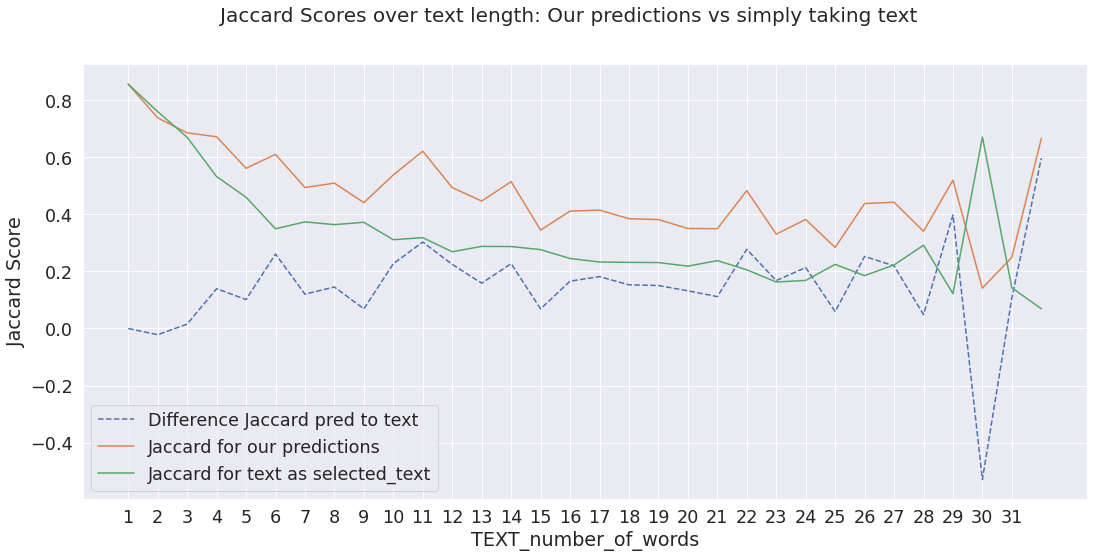

In [60]:
fig = plt.figure(figsize = (18,8) )
axes = plt.axes()
plot1 = sns.lineplot(x = 'TEXT_number_of_words', y = 'Diff_Jaccard_pred_vs_text',  label = 'Difference Jaccard pred to text', data = val_set_without_no_preds, ci = None)
plot1 = sns.lineplot(x = 'TEXT_number_of_words', y = 'Jaccard_prediction', label = 'Jaccard for our predictions', data = val_set_without_no_preds, ci = None)
plot1 = sns.lineplot(x = 'TEXT_number_of_words', y = 'Jaccard_text_sel_text', label = 'Jaccard for text as selected_text', data = val_set_without_no_preds, ci = None)
axes.set(ylabel = 'Jaccard Score', xticks = range(1,32))
axes.lines[0].set_linestyle("--")
cache = plt.legend() 
fig.suptitle('Jaccard Scores over text length: Our predictions vs simply taking text', fontsize = 20)
sns.set(font_scale = sns_default_font_scale) 

In [61]:
def make_final_predictions(splitAtLength, target_df, target_column):
    '''
    Loads the best models, predicting for each row in "target_df" and putting result in "target_column"
    OPTIMIZE HERE for better predictions!
    '''
    
    [model_pos_long_best, model_pos_short_best, model_neg_long_best, model_neg_short_best] = load_best_models(splitAtLength)
                 
    # Making it easier to deal with splitAtLength = None
    if splitAtLength is None:
        splitAtLength = 0
            
    target_df[target_column] = "EMPTY"
        
    for idx in target_df.index:
        text = target_df.at[idx,'text']
        sentiment = target_df.at[idx,'sentiment']
        
        if sentiment == 'neutral':  
            target_df.at[idx, target_column] = target_df.at[idx, 'text']
            # positive sentiment    
        elif sentiment == 'positive' and len(text.split()) > splitAtLength:
            target_df.at[idx, target_column] = make_predictions(text,
                                                                model_pos_long_best,
                                                                fill_no_predictions_with_text = True) if model_pos_long_best != None else text  
        elif sentiment == 'positive' and len(text.split()) <= splitAtLength:
            target_df.at[idx, target_column] = make_predictions(text,
                                                                model_pos_short_best,
                                                                fill_no_predictions_with_text = True) if model_pos_short_best != None else text
            # negative sentiment      
        elif sentiment == 'negative' and len(text.split()) > splitAtLength:
            target_df.at[idx, target_column] = make_predictions(text,
                                                                model_neg_long_best,
                                                                fill_no_predictions_with_text = True) if model_neg_long_best != None else text
        elif sentiment == 'negative' and len(text.split()) <= splitAtLength:
            target_df.at[idx, target_column] = make_predictions(text,
                                                                model_neg_short_best,
                                                                fill_no_predictions_with_text = True) if model_neg_short_best != None else text
        else:
            print('something is wrong with make_final_predictions()')
    return target_df

In [62]:
filled_test_df = make_final_predictions(splitAtLength, 
                                        test_df.copy(),
                                        target_column = "selected_text")

Models loaded:
Model_pos_long_best: True 
Model_pos_short_best: False 
Model_neg_long_best: True
Model_neg_short_best: False


In [63]:
submission_df = pd.read_csv(DATA_BASE_PATH + 'sample_submission.csv')
submission_df['selected_text'] = filled_test_df["selected_text"]
submission_df.to_csv("submission.csv", index = False)
display(submission_df.head(10))

,textID,selected_text
0,f87dea47db,Last session of the day http://twitpic.com/67ezh
1,96d74cb729,exciting
2,eee518ae67,Recession
3,01082688c6,happy bday!
4,33987a8ee5,I like it!!
5,726e501993,that`s great!! weee!! visitors!
6,261932614e,HATES
7,afa11da83f,completely blocked
8,e64208b4ef,and within a short time of the last clue all ...
9,37bcad24ca,What did you get? My day is alright.. haven`...
